In [ ]:
import random
import numpy as np
import pandas as pd
from scipy.io.wavfile import read as wavread

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import Model

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

root_path = '/content/drive/MyDrive'

MIC_NUM = 15

df = pd.read_csv('/content/drive/MyDrive/stats.csv')
files = df.iloc[:, 0].values
labels = df.iloc[:,-3:].values

files = [files[MIC_NUM*i : MIC_NUM*i + MIC_NUM] for i in range(int(len(files) // MIC_NUM))]
labels = np.array([labels[MIC_NUM*i] for i in range(int(len(labels) // MIC_NUM))]).astype(np.float32)

In [ ]:
matReshaped = np.loadtxt('/content/drive/MyDrive/mat.csv')
mat_shape = [4500, 15, 7721]
mat = matReshaped.reshape( matReshaped.shape[0], matReshaped.shape[1] // mat_shape[2], mat_shape[2])


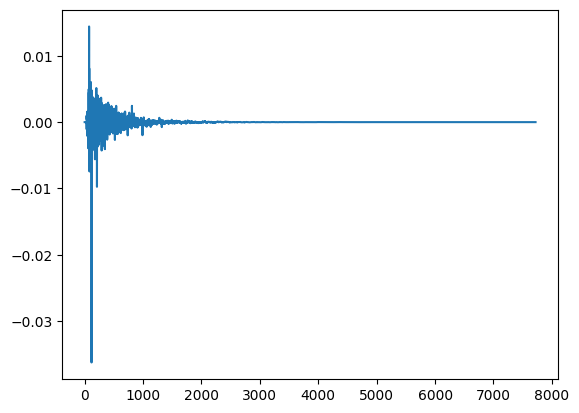

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mat[0, 0, :])
plt.show()

In [ ]:

x = labels_t[:, 0]
x = x-1.4

y = labels_t[:, 1]
y = y-4

z = labels_t[:, 2]
z = z-0.29999995

labels_t = np.stack((x, y, z), axis=1)

In [ ]:
ids = list(range(len(mat_t)))
random.shuffle(ids)
train_ids = ids[:int(.8*len(ids))]
test_ids = ids[int(.8*len(ids)):]
train_x = mat_t[train_ids]
train_y = labels_t[train_ids]
test_x = mat_t[test_ids]
test_y = labels_t[test_ids]

norm_layer = layers.Normalization()
train_x = np.transpose(train_x, (0, 2, 1))
test_x = np.transpose(test_x, (0, 2, 1))
print(train_x.shape)
print(train_y.shape)

(180, 7721, 15)
(180, 3)


In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = EfficientNetV2S(input_shape = (7222, 32, 3),
                                include_top = False,
                                weights = 'imagenet',
                                include_preprocessing = False)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.applications import ConvNeXtSmall
from tensorflow.keras import layers

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = ConvNeXtSmall(input_shape = (7222, 32, 3),
                                include_top = False,
                                weights = 'imagenet',
                                include_preprocessing = False)

for layer in pre_trained_model.layers:
  layer.trainable = False

198551472/198551472 [==============================] - 1s 0us/step


In [ ]:
last_layer = pre_trained_model.get_layer('top_bn')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 226, 1, 1280)


In [ ]:
model = models.Sequential([
    layers.Conv2D(5, (500,1), input_shape=(7721, 15, 1)),
    layers.BatchNormalization(),
    layers.Conv1D(32, 3, data_format='channels_first'),
    layers.BatchNormalization(),
    pre_trained_model,
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(512, activation= tf.keras.layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.Dense(1024, activation= tf.keras.layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.Dense(1024, activation= tf.keras.layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.Dense(512, activation= tf.keras.layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.Dense(256, activation= tf.keras.layers.LeakyReLU()),
    layers.BatchNormalization(),
    layers.Dense(3),
])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adagrad(),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[],
)

In [ ]:
model.load_weights('/content/drive/MyDrive/my_model_weights_final.h5')

In [ ]:
EPOCHS = 300
history = model.fit(
    train_x,
    train_y,
    validation_data = (test_x, test_y),
    epochs=EPOCHS,
    batch_size = 4
)

Epoch 1/300
45/45 [==============================] - 40s 387ms/step - loss: 6.8318 - val_loss: 6.2178
Epoch 2/300
45/45 [==============================] - 12s 256ms/step - loss: 5.8015 - val_loss: 9.6682
Epoch 3/300
45/45 [==============================] - 12s 258ms/step - loss: 5.4360 - val_loss: 9.1141
Epoch 4/300
45/45 [==============================] - 12s 259ms/step - loss: 5.2297 - val_loss: 5.6142
Epoch 5/300
45/45 [==============================] - 12s 260ms/step - loss: 4.9656 - val_loss: 4.0431
Epoch 6/300
45/45 [==============================] - 12s 262ms/step - loss: 4.7330 - val_loss: 3.5142
Epoch 7/300
45/45 [==============================] - 12s 264ms/step - loss: 4.5668 - val_loss: 3.5547
Epoch 8/300
45/45 [==============================] - 12s 264ms/step - loss: 4.4637 - val_loss: 3.3277
Epoch 9/300
45/45 [==============================] - 12s 266ms/step - loss: 4.3265 - val_loss: 4.0350
Epoch 10/300
45/45 [==============================] - 12s 268ms/step - loss: 4.225

In [ ]:
predictions = model.predict(test_x)
print(predictions[1:5], test_y[1:5])


2/2 [==============================] - 4s 561ms/step
[[-2.6699805 -2.3963015  2.6620538]
 [-2.0013177 -2.591444   2.8098528]
 [-2.2794921 -2.5692122  2.7990043]
 [-2.6297626 -2.4901705  2.632736 ]] [[-2.46      -2.22       2.7      ]
 [-1.74      -2.58       2.7      ]
 [-2.28      -2.46       2.7      ]
 [-2.82      -2.1599998  2.7      ]]


In [ ]:
model.save_weights('/content/drive/MyDrive/my_model_weights_final.h5')

In [ ]:
model.save('/content/drive/MyDrive/my_model_final.keras')

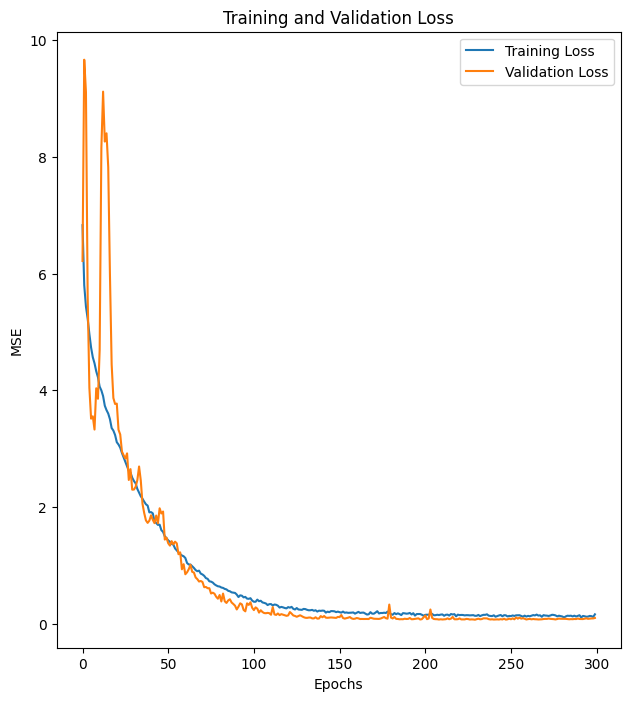

In [ ]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()